In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df=pd.read_csv(r"C:\Users\OJ 001\Downloads\health_insurance_dataset.csv")

In [5]:
df.columns

Index(['customerID', 'age', 'gender', 'bmi', 'smoker', 'region', 'children',
       'annual_income', 'claim_history', 'annual_premium', 'high_cost_claim'],
      dtype='object')

In [6]:
#cleaning the columns 
df.columns = df.columns.str.strip().str.title()

In [7]:

# 1. Check for missing values
print("\nMissing values per column:\n", df.isnull().sum())

# 2. Check duplicates
duplicates = df.duplicated().sum()
print("\nNumber of duplicate rows:", duplicates)

# 3. Check data types
print("\nData types:\n", df.dtypes)

# 4. Basic statistics (for spotting outliers & ranges)
print("\nSummary statistics:\n", df.describe())



Missing values per column:
 Customerid         0
Age                0
Gender             0
Bmi                0
Smoker             0
Region             0
Children           0
Annual_Income      0
Claim_History      0
Annual_Premium     0
High_Cost_Claim    0
dtype: int64

Number of duplicate rows: 0

Data types:
 Customerid          object
Age                  int64
Gender              object
Bmi                float64
Smoker              object
Region              object
Children             int64
Annual_Income        int64
Claim_History        int64
Annual_Premium       int64
High_Cost_Claim     object
dtype: object

Summary statistics:
               Age          Bmi    Children  Annual_Income  Claim_History  \
count  1000.00000  1000.000000  1000.00000    1000.000000    1000.000000   
mean     43.81900    28.402000     2.04700   75309.880000       1.915000   
std      14.99103     4.966236     1.39382   26453.769263       1.305174   
min      18.00000    13.400000     0.00000   30

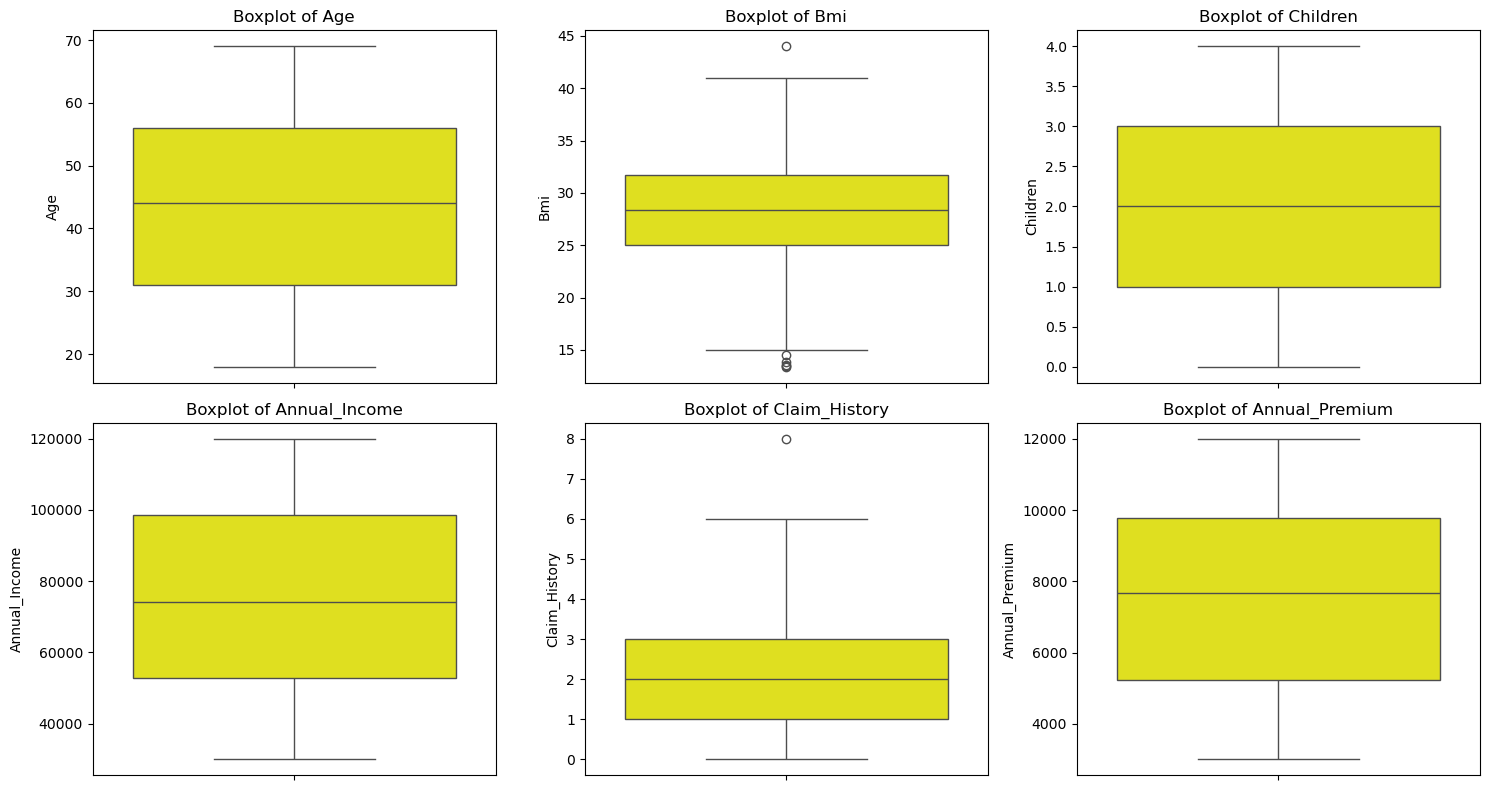


🔎 Outliers in Age: 0 rows

🔎 Outliers in Bmi: 6 rows
    Customerid   Bmi
183      H0184  13.8
223      H0224  13.5
661      H0662  13.6
713      H0714  13.4
737      H0738  44.0

🔎 Outliers in Children: 0 rows

🔎 Outliers in Annual_Income: 0 rows

🔎 Outliers in Claim_History: 1 rows
    Customerid  Claim_History
353      H0354              8

🔎 Outliers in Annual_Premium: 0 rows


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns
num_cols = ["Age", "Bmi", "Children", "Annual_Income", "Claim_History", "Annual_Premium"]

# 1. Boxplots for quick visual check
plt.figure(figsize=(15, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col], color="yellow")
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()


# 2. Function to detect outliers using IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Boolean mask for outliers
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers


# 3. Detect outliers column by column
for col in num_cols:
    outliers = detect_outliers_iqr(df, col)
    print(f"\n🔎 Outliers in {col}: {len(outliers)} rows")
    if not outliers.empty:
        print(outliers[["Customerid", col]].head())  # show first few with ID


In [40]:
#Handling BMI with outlier
Q1 = df["Bmi"].quantile(0.25)
Q3 = df["Bmi"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"BMI lower bound: {lower_bound:.2f}, upper bound: {upper_bound:.2f}")

BMI lower bound: 14.95, upper bound: 41.75


In [42]:
#We use winsorization (replace outliers with nearest valid bound)

df["Bmi"] = np.where(df["Bmi"] < lower_bound, lower_bound,
              np.where(df["Bmi"] > upper_bound, upper_bound, df["Bmi"]))


#If BMI is below the lower bound → replace with lower bound.

#If BMI is above the upper bound → replace with upper bound.

#Otherwise → keep the value.

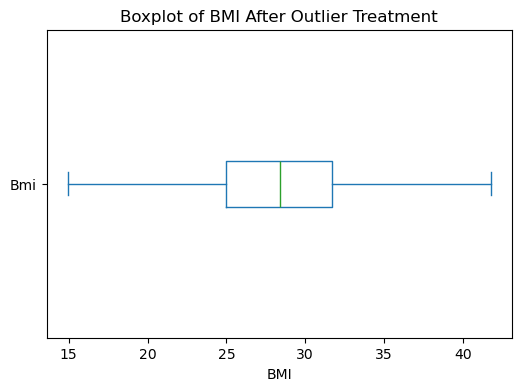

count    1000.000000
mean       28.405700
std         4.942691
min        14.950000
25%        25.000000
50%        28.400000
75%        31.700000
max        41.750000
Name: Bmi, dtype: float64


In [44]:
#a box plot after capping 

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

# Boxplot for BMI after capping
df["Bmi"].plot(kind="box", vert=False)
plt.title("Boxplot of BMI After Outlier Treatment")
plt.xlabel("BMI")
plt.show()

# Also check the summary stats
print(df["Bmi"].describe())


In [9]:
#turn BMI into human-interpretable bins (often predictive for health cost)

bins = [0, 18.5, 24.9, 29.9, np.inf]
labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
df['Bmi_Category'] = pd.cut(df['Bmi'], bins=bins, labels=labels, right=True)


In [10]:
#grouping ages
age_bins = [0, 29, 49, np.inf]
age_labels = ['Young', 'Adult', 'Senior']
df['Age_Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels)


In [11]:
# qcut may fail if few unique values — wrap in try
try:
    df['Income_Bracket'] = pd.qcut(df['Annual_Income'], q=3, labels=['Low','Medium','High'])
except ValueError:
    # fallback to cut if qcut fails
    df['Income_Bracket'] = pd.cut(df['Annual_Income'], bins=3, labels=['Low','Medium','High'])


In [12]:
#Income per child (handles division-by-zero)
df['Income_per_Child'] = df['Annual_Income'] / (df['Children'] + 1)


In [13]:
#Premium-to-income ratio
df['Premium_to_Income_Ratio'] = df['Annual_Premium'] / df['Annual_Income']


In [14]:
#Binary flags from categorical fields (safe mapping)
df['Smoker_flag'] = (df['Smoker'].astype(str).str.strip().str.lower().map({'yes':1,'no':0})).fillna(0).astype(int)
df['Is_Female'] = (df['Gender'].astype(str).str.strip().str.lower().map({'female':1,'male':0})).fillna(0).astype(int)


In [15]:
#High claim history flag
df['High_claim_history_flag'] = (df['Claim_History'] >= 3).astype(int)


In [16]:
#Obesity flag & smoker–obese interaction
df['Is_Obese'] = (df['Bmi'] >= 30).astype(int)
df['Smoker_Obese'] = df['Smoker_flag'] * df['Is_Obese']


In [17]:
#Simple (interpretable) risk score

df['Risk_Score_raw'] = (
      0.35 * df['Smoker_flag']
    + 0.25 * df['Is_Obese']
    + 0.20 * (df['Age'] > 50).astype(int)
    + 0.20 * (df['Claim_History'] >= 3).astype(int)
)

# normalize 0-1
minv = df['Risk_Score_raw'].min()
maxv = df['Risk_Score_raw'].max()
if maxv > minv:
    df['Risk_Score'] = (df['Risk_Score_raw'] - minv) / (maxv - minv)
else:
    df['Risk_Score'] = df['Risk_Score_raw']


In [18]:
#Log transforms for skewed monetary features
df['Log_Annual_Income'] = np.log1p(df['Annual_Income'])
df['Log_Annual_Premium'] = np.log1p(df['Annual_Premium'])


In [19]:
#Interaction features (optional but often useful)
df['Age_by_Premium'] = df['Age'] * df['Annual_Premium']
df['Premium_per_Child'] = df['Annual_Premium'] / (df['Children'] + 1)


In [21]:
df.head(5)

,Customerid,Age,Gender,Bmi,Smoker,Region,Children,Annual_Income,Claim_History,Annual_Premium,...,Is_Female,High_claim_history_flag,Is_Obese,Smoker_Obese,Risk_Score_raw,Risk_Score,Log_Annual_Income,Log_Annual_Premium,Age_by_Premium,Premium_per_Child
0,H0001,56,Male,27.9,No,Southwest,1,39130,3,3246,...,0,1,0,0,0.40,0.40,10.574670,8.085487,181776,1623.0
1,H0002,69,Male,33.9,No,Southwest,1,119360,1,7825,...,0,0,1,0,0.45,0.45,11.689908,8.965207,539925,3912.5
2,H0003,46,Male,40.6,No,Southeast,1,92287,2,9516,...,0,0,1,0,0.25,0.25,11.432669,9.160835,437736,4758.0
3,H0004,32,Female,25.3,No,Northeast,0,81702,1,3416,...,1,0,0,0,0.00,0.00,11.310846,8.136518,109312,3416.0
4,H0005,60,Male,25.6,No,Southeast,4,66993,2,9702,...,0,0,0,0,0.20,0.20,11.112358,9.180190,582120,1940.4


In [22]:
df.to_csv("health_insurance_features_engineered.csv", index=False)
print("Saved: health_insurance_features_engineered.csv")

Saved: health_insurance_features_engineered.csv
